## Perturbation of sequences
### Dataset: UniProt SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

1019

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(32347819, 15)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.014662,0.000120,0.000159,0.009493,0.000217,0.975218,0.000026,0.000106,A0A8B1JQG7,Human,N,382,A,-0.000090,0.000090
1,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,N,1682,H,0.000000,0.000000
2,0.016292,0.000111,0.000143,0.008804,0.000225,0.974300,0.000025,0.000100,A0A8B1JQG7,Human,X,647,H,-0.001007,0.001007
3,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,Q,1912,T,0.000000,0.000000
4,0.014808,0.000116,0.000150,0.009277,0.000215,0.975307,0.000025,0.000102,A0A8B1JQG7,Human,V,1383,H,0.000000,0.000000


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

In [9]:
# plt.clf()
# plt.figure(figsize=(48, 16))
# plt.rcParams['xtick.labelsize'] = 24
# plt.rcParams['ytick.labelsize'] = 24
# sns.distplot(perturbed_output_df["Human_pred_diff"])
# plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.752989,-0.673820,72,0.000223
1,-0.673820,-0.594650,231,0.000714
2,-0.594650,-0.515480,723,0.002235
3,-0.515480,-0.436310,154,0.000476
4,-0.436310,-0.357140,565,0.001747
5,-0.357140,-0.277970,692,0.002139
6,-0.277970,-0.198800,619,0.001914
7,-0.198800,-0.119631,3042,0.009404
8,-0.119631,-0.040461,17141,0.052990
9,-0.040461,0.038709,32289348,99.819243


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 15637
Number of unique positions = 73
Unique positions = [469. 468. 467. 293. 303. 295. 309. 298. 292. 299. 307. 597. 301. 596.
 288. 109. 107. 294. 296. 302. 211. 466. 308. 300. 533. 584. 106. 470.
 316. 240. 314. 575. 313. 304. 310. 287. 586. 311. 315. 290. 326. 306.
 583. 297. 516. 305. 291. 598. 289. 312. 258. 241. 250. 286. 417. 318.
 105. 242. 319. 317. 285. 276. 248. 275. 283. 321. 284. 260. 277. 324.
 249. 320. 282.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_289146/3825924755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-multi"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
3170,0.729948,0.000211,0.000007,0.002718,0.067744,0.197221,0.002031,0.000121,A0A8B1JGY8,Human,D,982,H,-0.752989,0.752989,467.0,sarscov2-uniprot-aligned-multi
30635,0.738809,0.000205,0.000006,0.002555,0.071055,0.185175,0.002079,0.000115,A0A7D5UC98,Human,D,982,H,-0.747413,0.747413,467.0,sarscov2-uniprot-aligned-multi
12213,0.724698,0.000215,0.000007,0.002843,0.065369,0.204720,0.002023,0.000124,A0A8B6RMZ9,Human,D,982,H,-0.745023,0.745023,467.0,sarscov2-uniprot-aligned-multi
3574,0.735209,0.000211,0.000007,0.002631,0.070890,0.188806,0.002128,0.000119,A0A6M4NDS5,Human,D,982,H,-0.744586,0.744586,467.0,sarscov2-uniprot-aligned-multi
15704,0.730549,0.000209,0.000007,0.002721,0.066958,0.197339,0.002096,0.000121,A0A8B6R9R3,Human,D,982,H,-0.741501,0.741501,467.0,sarscov2-uniprot-aligned-multi
22536,0.723666,0.000208,0.000007,0.002870,0.064888,0.206169,0.002070,0.000120,A0A8B1JYT9,Human,D,982,H,-0.740819,0.740819,467.0,sarscov2-uniprot-aligned-multi
4762,0.712644,0.000233,0.000009,0.003223,0.066727,0.214725,0.002304,0.000135,A0A8B6RF56,Human,D,982,H,-0.737056,0.737056,467.0,sarscov2-uniprot-aligned-multi
9718,0.724309,0.000227,0.000007,0.002829,0.069360,0.200997,0.002140,0.000130,A0A7U3HJV4,Human,D,982,H,-0.736590,0.736590,467.0,sarscov2-uniprot-aligned-multi
12241,0.721581,0.000208,0.000007,0.002867,0.063637,0.209530,0.002048,0.000122,A0A8B1JLH2,Human,D,982,H,-0.734036,0.734036,467.0,sarscov2-uniprot-aligned-multi
16339,0.708632,0.000226,0.000009,0.003106,0.059837,0.226123,0.001933,0.000136,A0A8B6RS06,Human,D,982,H,-0.731072,0.731072,467.0,sarscov2-uniprot-aligned-multi


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_289146/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Cat,Cattle,Chicken,Dromedary camel,Gray wolf,Human,Pig,Yak,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
6878,0.140059,0.000194,0.000089,0.012897,0.002654,0.843656,0.000278,0.000174,A0A8B1JQG7,Human,S,984,H,-0.131651,0.131651,469.0,sarscov2-uniprot-aligned-multi,469.0_H
12836,0.131768,0.000201,0.000101,0.014153,0.002517,0.850805,0.000276,0.000179,A0A8B1JQG7,Human,I,983,H,-0.124502,0.124502,468.0,sarscov2-uniprot-aligned-multi,468.0_H
15508,0.298555,0.000390,0.000071,0.012706,0.012175,0.674678,0.001099,0.000325,A0A8B1JQG7,Human,D,982,H,-0.300629,0.300629,467.0,sarscov2-uniprot-aligned-multi,467.0_H
3458,0.183530,0.000111,0.000059,0.008945,0.002564,0.804471,0.000216,0.000104,A0A8B1JLN2,Human,S,984,H,-0.152118,0.152118,469.0,sarscov2-uniprot-aligned-multi,469.0_H
17519,0.177356,0.000116,0.000067,0.009775,0.002513,0.809845,0.000221,0.000108,A0A8B1JLN2,Human,I,983,H,-0.146743,0.146743,468.0,sarscov2-uniprot-aligned-multi,468.0_H


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,105.0_H,0.106662,105.0,H
1,106.0_H,0.186916,106.0,H
2,106.0_X,0.128941,106.0,X
3,107.0_X,0.103953,107.0,X
4,109.0_H,0.103346,109.0,H


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
125,467.0_H,0.470063,467.0,H
129,469.0_H,0.327297,469.0,H
127,468.0_H,0.319750,468.0,H
137,533.0_W,0.298146,533.0,W
142,596.0_H,0.275101,596.0,H
131,470.0_H,0.273088,470.0,H
139,583.0_H,0.232791,583.0,H
63,308.0_H,0.215541,308.0,H
89,309.0_H,0.188457,309.0,H
1,106.0_H,0.186916,106.0,H


<Figure size 432x288 with 0 Axes>

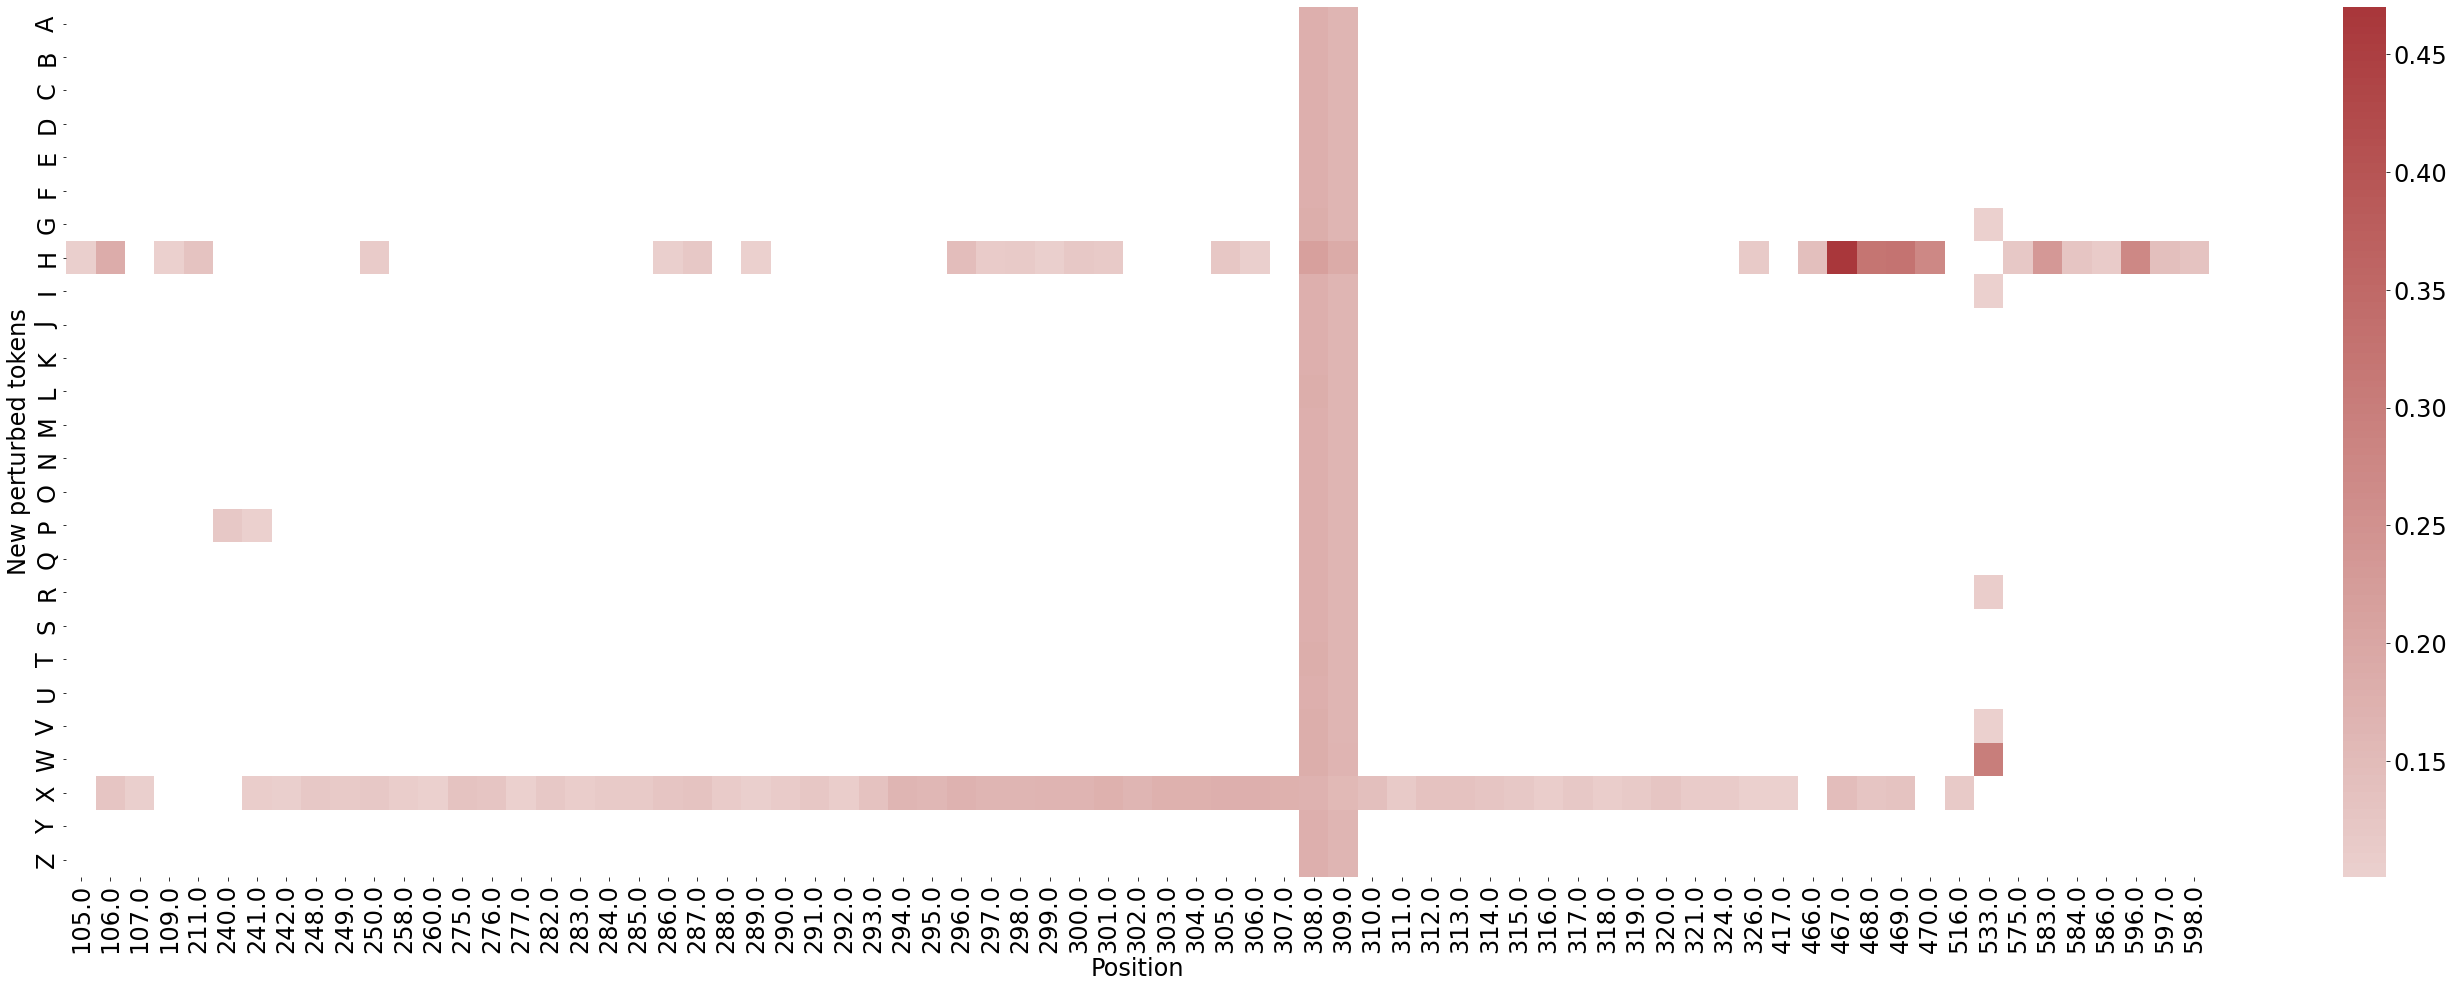

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
105.0    0.106662
106.0    0.157929
107.0    0.103953
109.0    0.103346
211.0    0.130278
           ...   
584.0    0.126454
586.0    0.112177
596.0    0.275101
597.0    0.141764
598.0    0.130259
Length: 73, dtype: float64

<Figure size 432x288 with 0 Axes>

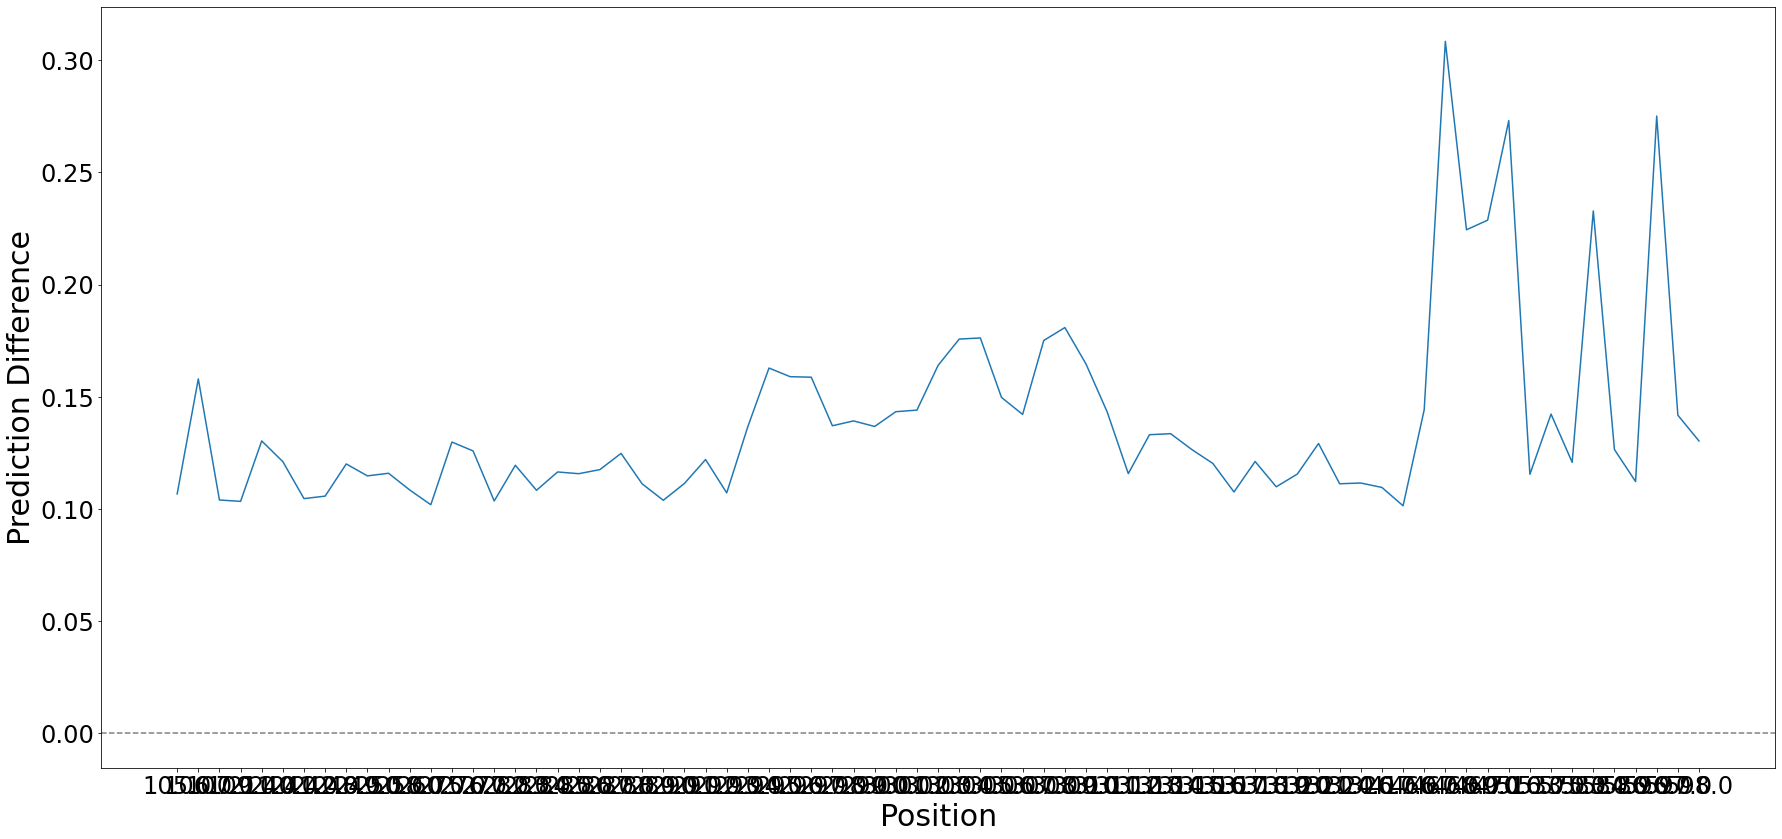

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()